# Reinforcement Learning (MO436)

## 👻 **Pac-Man**

### Autores:

* **Aline Cavalca Carvalho Soares de Azevedo** (RA: 189593)

* **Beatriz Cardoso Nascimento**               (RA: 247403)

* **Daniel Gardin Gratti**                     (RA: 214729)

* **Guilhermo de Luiggi Mocelim de Oliveira** (RA: 223325)


### Professora:
* Esther Luna Colombini

## Importando Bibliotecas

In [ ]:
from collections import defaultdict
from pacman.actions import Actions
from pacman.env import PacmanEnv
from pacman.agents import Agent

import matplotlib.pyplot as plt
from time import perf_counter
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np

sns.set_theme('notebook', style= 'darkgrid')
plt.style.use('dark_background')

pygame 2.5.2 (SDL 2.28.2, Python 3.9.16)
Hello from the pygame community. https://www.pygame.org/contribute.html






## Introdução

*Reinforcement Learning* (Aprendizado por Reforço) representa um paradigma fundamental da Inteligência Artificial focado no controle de sistemas dinâmicos.

No âmbito desse paradigma, escolhemos a formulação de um Problema de Decisão de Markov (MDP) aplicado ao icônico jogo **Pac-Man**.

Para a implementação, adotamos o modelo de discretização de grid para representar o ambiente, cuja natureza sequencial caracteriza-o como não episódico. Nesse contexto, temos 3 estados terminais que são alcançados ao consumir a comida, colidir com um fantasma ou após 100 passos do Pac-Man.

Criamos dois ambientes simples para testar algoritmos de Aprendizado por reforço, um determinístico, com a introdução do fantasma `RobustGhost`, que resolve um pequeno minimax de profundidade 2 para determinar a melhor ação, e seu versão estocástica `StochasticRobustGhost`, que realiza ações sub-ótimas com certa probabilidade.

In [ ]:
deterministic_env = PacmanEnv.contourDanger(4, ghost_names= "RobustGhost")
stochastic_env    = PacmanEnv.contourDanger(4, ghost_names= "StochasticRobustGhost")

In [ ]:
stochastic_env.reset()

% % % % % %
% .       %
%   G     %
%     P   %
%         %
% % % % % %
Score: 0


(((3, 2), (0.0,), ((2, 3),), ('No action',), (0,)), False)

In [ ]:
def plot_episodes(history, metrics, smooth=101, alpha=0.4):
    if isinstance(metrics, str):
        metrics = [metrics]

    n_metrics = len(metrics)

    fig, axs = plt.subplots(ncols=n_metrics,figsize=(8*n_metrics, 5))

    axs = np.atleast_1d(axs)

    colors = ['#feebe2', '#fcc5c0', '#fa9fb5', '#f768a1', '#c51b8a', '#7a0177']

    for ax, metric in zip(axs, metrics):
        for (n0,hist), color in zip(history.items(),colors):
            episodes = np.array(hist[metric]).squeeze()

            ax.plot(episodes, alpha=alpha)

            padded_episodes = np.pad(episodes, (smooth//2,smooth//2), 'edge')
            smooth_episodes = np.convolve(padded_episodes, np.ones(smooth)/smooth, mode='valid')

            ax.plot(smooth_episodes, linewidth=1, color=color, label= n0)

        ax.set_title(f"{metric.capitalize()} during training")
        ax.set_ylabel(metric)
        ax.set_xlabel("episode")
        ax.legend()

    return fig, axs

In [ ]:
class EpsilonGreedyQAgent(Agent):
    """
    Agent with internal Q table and epsilon-greedy policy. Can learn from a control algorithm.
    """

    def __init__(self):
        self.Qtable = defaultdict(lambda : {action: 0. for action in Actions.actions})


    def act(self, state, epsilon=0.) -> str:
        if np.random.rand() > epsilon:
            # Realiza um passo guloso de acordo com os valores Q aprendidos
            action, _ = self.max_Q(state)

        else:
            # Amostra uma ação aleatória dentre as ações disponíveis
            action = Actions.sample()

        return action


    def Q(self, state, action):
        return self.Qtable[state][action]


    def max_Q(self, state):
        action_values = self.Qtable[state]

        action = max(action_values, key=lambda k : action_values[k])

        return action, action_values[action]


    def update_Q(self, state, action, alpha, error):
        self.Qtable[state][action] += alpha * error


    def reset(self):
        """
        Reset agent's Q table.
        """
        self.Qtable.clear()

In [ ]:
metrics = ["Mean reward", "Mean length", "Mean winrate", "Training time"]

configs = ["Environment", "Policy", "Algorithm"]

index = pd.MultiIndex(levels=[[] for _ in range(len(configs))], codes=[[] for _ in range(len(configs))], names=configs)
results = pd.DataFrame(index=index, columns=metrics)

In [ ]:
def evaluate(env, policy, control, parameter, values, n_episodes=10000):
    history = {}

    df = pd.DataFrame(columns=metrics)

    for value in values:
        performances = dict(zip(metrics, [0.] * len(metrics)))

        setattr(control, parameter, value)

        initial_time = perf_counter()
        _, hist = control.train(policy, n_episodes)
        performances["Training time"] = perf_counter() - initial_time

        history[value] = hist

        n_repetitions = 100 if env.is_stochastic() else 1

        for _ in range(n_repetitions):
            env.run_policy(policy)

            performances["Mean reward"]  += env.get_score()
            performances["Mean length"]  += env.current_step
            performances["Mean winrate"] += int(env.is_win())

        performances["Mean reward"]  /= n_repetitions
        performances["Mean length"]  /= n_repetitions
        performances["Mean winrate"] /= n_repetitions


        df.loc[value, :] = performances

        policy.reset()

    return history, df

### Monte Carlo

O modelo baseado em Monte Carlo tem como principal característica utilizar episódios completos para aprender. A função Q é atualizada ao final de um episódio com base nas recompensas acumuladas ao longo de todo o episódio. Implementamos o Método de Monte Carlo para nossa formulação MDP do jogo PacMan, tanto para o caso determinístico como para o caso estocástico. Realizamos experimentos variando o N0 para explorar os efeitos dessa constante na convergência dos resultados do modelo.

In [ ]:
class MonteCarloControl:
    def __init__(self, env, gamma, alpha=None, N0=1):
        self.env   = env
        self.gamma = gamma
        self.alpha = alpha
        self.N0    = N0


    def train(self, policy, max_episodes=1000):
        history = {
            "cumulative reward"  : [],
            "episode error"      : [],
            "episode length"     : [],
            "episode win"        : []
        }

        Ntable  = defaultdict(lambda : {action: 0 for action in Actions.actions})

        for _ in tqdm(range(max_episodes)):

            state, done = self.env.reset(random_init=True)
            cumulative_reward = 0
            cumulative_error  = 0
            n_steps           = 0

            while not done:
                epsilon = self.N0 / (self.N0 + sum(Ntable[state].values()))

                action = policy.act(state, epsilon)

                next_state, reward, done, info = self.env.step(action)

                Ntable[state][action] += 1
                n_steps += 1

                cumulative_reward = (self.gamma * cumulative_reward) + reward

                alpha = 1/Ntable[state][action] if self.alpha is None else self.alpha
                error = (cumulative_reward - policy.Q(state, action))

                policy.update_Q(state, action, alpha, error)

                cumulative_error += abs(error)

                state  = next_state

            mean_error = cumulative_error / self.env.current_step

            history["cumulative reward"].append(cumulative_reward)
            history["episode error"].append(mean_error)
            history["episode length"].append(n_steps)
            history["episode win"].append(self.env.is_win())

        return policy, history

In [ ]:
history, performance = evaluate(
    deterministic_env,
    EpsilonGreedyQAgent(),
    MonteCarloControl(deterministic_env.set_render(None), 0.99),
    "N0",
    [0.01, 0.1, 1, 10, 100]
)

performance

  0%|          | 29/10000 [00:00<00:40, 244.13it/s]

100%|██████████| 10000/10000 [00:14<00:00, 667.07it/s]


,Mean reward,Mean length,Mean winrate,Training time
0.01,-103.0,101.0,0.0,100.604079
0.10,-101.0,101.0,0.0,118.657028
1.00,37.0,11.0,1.0,9.943392
10.00,35.0,15.0,1.0,15.346718
100.00,31.0,18.0,1.0,14.992824


In [ ]:
best = performance["Mean reward"].to_numpy().argmax()

results.loc[("Deterministic", "Classic", "Monte Carlo"), :] = performance.iloc[best]

results

,,,Mean reward,Mean length,Mean winrate,Training time
Environment,Policy,Algorithm,,,,
Deterministic,Classic,Monte Carlo,37.0,11.0,1.0,9.943392


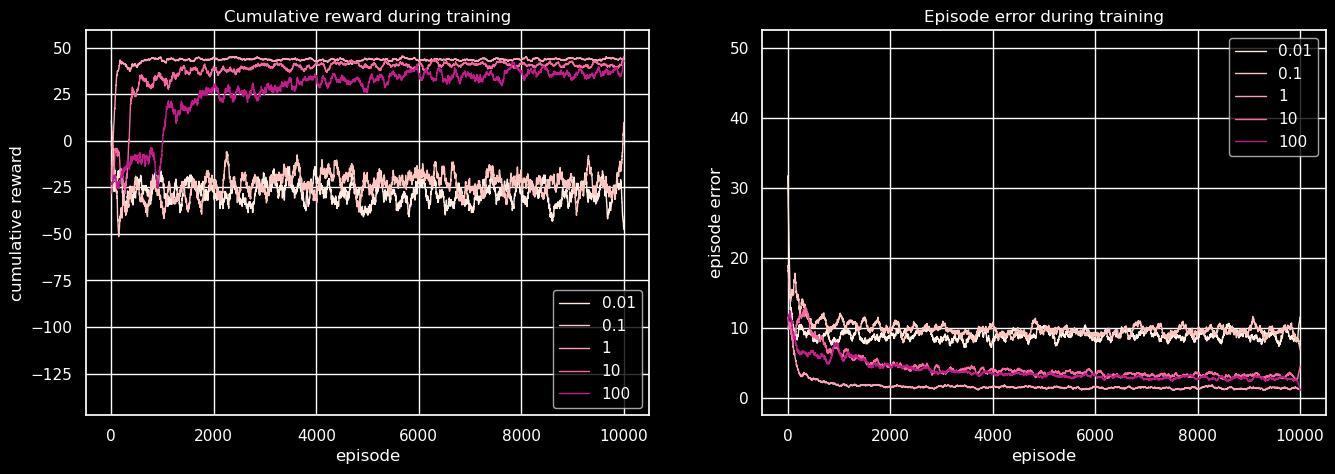

In [ ]:
plot_episodes(history, ['cumulative reward', 'episode error'],  alpha=0)
plt.show()

Acima podemos observar o resultado para o caso determinístico. Verificamos que o N0=1 foi o de melhor resultado. Os N0s de valor baixo (a saber 0.01, 0.1) tiveram um desempenho ruim e convergiram para uma recompensa acumulada em torno de -25. Esse comportamento pode ser explicado pelo fato da constante N0 ser ligada ao $\epsilon$ da política $\epsilon$-greedy, ou seja, quanto maior o N0, maior a exploração do ambiente. Inferimos portanto que os N0s baixos tiveram estratégias que se basearam demais nas primeiras épocas e não exploraram muito o ambiente, o que explica o resultado indesejado. Observando o comportamento do gráfico para N0=100, fica clara a variação da recompensa acumulada e a maior exploração do ambiente até ocorrer a convergëncia. Com relação ao erro durante o treinamento, o melhor resultado também é associado ao N0=1, em segundo lugar, N0=100, que convergiram para o menor erro.

In [ ]:
history, performance = evaluate(
    stochastic_env,
    EpsilonGreedyQAgent(),
    MonteCarloControl(stochastic_env.set_render(None), 0.99),
    "N0",
    [0.01, 0.1, 1, 10, 100]
)

performance

100%|██████████| 10000/10000 [00:17<00:00, 566.77it/s]


,Mean reward,Mean length,Mean winrate,Training time
0.01,27.7,15.9,0.93,15.216962
0.10,21.59,15.61,0.83,22.052714
1.00,28.49,19.21,0.99,24.193515
10.00,36.88,11.98,0.99,12.689994
100.00,35.98,13.9,1.0,17.644891


In [ ]:
best = performance["Mean reward"].to_numpy().argmax()

results.loc[("Stochastic", "Classic", "Monte Carlo"), :] = performance.iloc[best]

results

,,,Mean reward,Mean length,Mean winrate,Training time
Environment,Policy,Algorithm,,,,
Deterministic,Classic,Monte Carlo,37.0,11.0,1.0,9.943392
Stochastic,Classic,Monte Carlo,36.88,11.98,0.99,12.689994


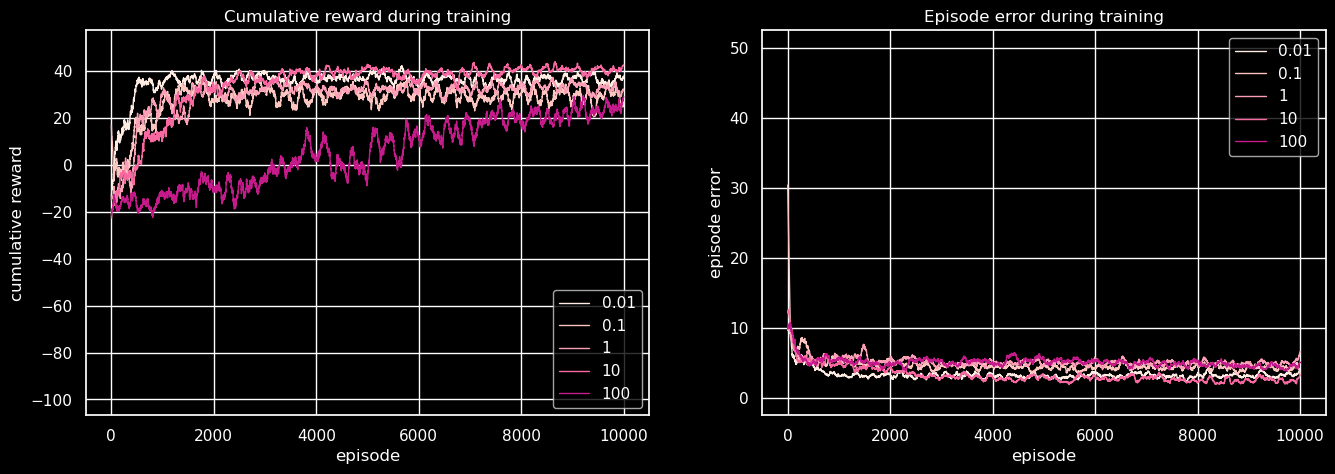

In [ ]:
plot_episodes(history, ['cumulative reward', 'episode error'],  alpha=0)
plt.show()

Os resultados acima se referem ao ambiente estocástico. Observamos que quase todos os N0 convergiram para uma mesma recompensa acumulada e os erros por episódio também foram mais baixos, ou seja, num panorama geral os resultados foram melhores que os do ambiente determinístico.


### Q-Learning

In [ ]:
class QLearning():
    def __init__(self, env, gamma, alpha=1., N0=1):
        self.env   = env
        self.gamma = gamma
        self.alpha = alpha
        self.N0    = N0


    def train(self, policy, max_episodes=1000):
        history = {
            "cumulative reward"  : [],
            "episode error"      : [],
            "episode length"     : [],
            "episode win"        : []
        }

        Ntable = defaultdict(lambda : {action: 0 for action in Actions.actions})

        for _ in tqdm(range(max_episodes)):
            state, done = self.env.reset(random_init=True)
            cumulative_reward = 0
            cumulative_error  = 0

            n_steps = 0

            while not done:
                epsilon = self.N0 / (self.N0 + sum(Ntable[state].values()))

                action = policy.act(state, epsilon)
                next_state, reward, done, info = self.env.step(action)

                Ntable[state][action] += 1
                n_steps += 1

                cumulative_reward = (self.gamma * cumulative_reward) + reward

                _, Qmax = policy.max_Q(next_state)

                td_error = reward + self.gamma * Qmax - policy.Q(state, action)

                cumulative_error += abs(td_error)

                alpha = self.alpha/Ntable[state][action]

                policy.update_Q(state, action, alpha, td_error)

                state  = next_state

            history["cumulative reward"].append(cumulative_reward)
            history["episode error"].append(cumulative_error)
            history["episode length"].append(n_steps)
            history["episode win"].append(self.env.is_win())

        return policy, history

In [ ]:
history, performance = evaluate(
    deterministic_env,
    EpsilonGreedyQAgent(),
    QLearning(deterministic_env.set_render(None), 0.99),
    "gamma",
    [0, 0.2, 0.4, 0.6, 0.8, 0.99]
)

performance

100%|██████████| 10000/10000 [00:07<00:00, 1407.04it/s]


,Mean reward,Mean length,Mean winrate,Training time
0.00,-101.0,101.0,0.0,114.57237
0.20,45.0,5.0,1.0,6.241794
0.40,45.0,5.0,1.0,5.896278
0.60,45.0,5.0,1.0,6.202526
0.80,43.0,7.0,1.0,7.101144
0.99,43.0,7.0,1.0,7.108496


In [ ]:
best = performance["Mean reward"].to_numpy().argmax()

results.loc[("Deterministic", "Classic", "Q-Learning"), :] = performance.iloc[best]

results

,,,Mean reward,Mean length,Mean winrate,Training time
Environment,Policy,Algorithm,,,,
Deterministic,Classic,Monte Carlo,37.0,11.0,1.0,9.943392
Stochastic,Classic,Monte Carlo,36.88,11.98,0.99,12.689994
Deterministic,Classic,Q-Learning,45.0,5.0,1.0,6.241794


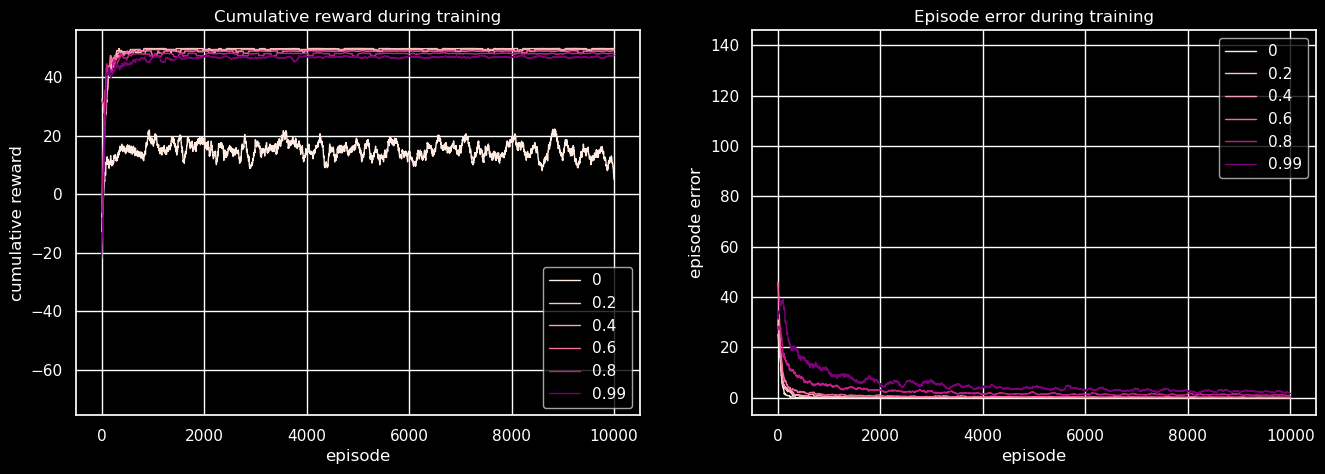

In [ ]:
plot_episodes(history, ['cumulative reward', 'episode error'],  alpha=0)
plt.show()

In [ ]:
history, performance = evaluate(
    stochastic_env,
    EpsilonGreedyQAgent(),
    QLearning(stochastic_env.set_render(None), 0.99),
    "gamma",
    [0, 0.2, 0.4, 0.6, 0.8, 0.99]
)

performance

100%|██████████| 10000/10000 [00:09<00:00, 1047.26it/s]


,Mean reward,Mean length,Mean winrate,Training time
0.00,-101.87,101.0,0.0,97.770935
0.20,39.64,10.01,0.99,10.962558
0.40,41.54,8.68,1.0,8.59114
0.60,41.66,8.6,1.0,9.148927
0.80,37.92,11.34,1.0,7.889779
0.99,40.32,9.68,1.0,9.549944


In [ ]:
best = performance["Mean reward"].to_numpy().argmax()

results.loc[("Stochastic", "Classic", "Q-Learning"), :] = performance.iloc[best]

results

,,,Mean reward,Mean length,Mean winrate,Training time
Environment,Policy,Algorithm,,,,
Deterministic,Classic,Monte Carlo,37.0,11.0,1.0,9.943392
Stochastic,Classic,Monte Carlo,36.88,11.98,0.99,12.689994
Deterministic,Classic,Q-Learning,45.0,5.0,1.0,6.241794
Stochastic,Classic,Q-Learning,41.66,8.6,1.0,9.148927


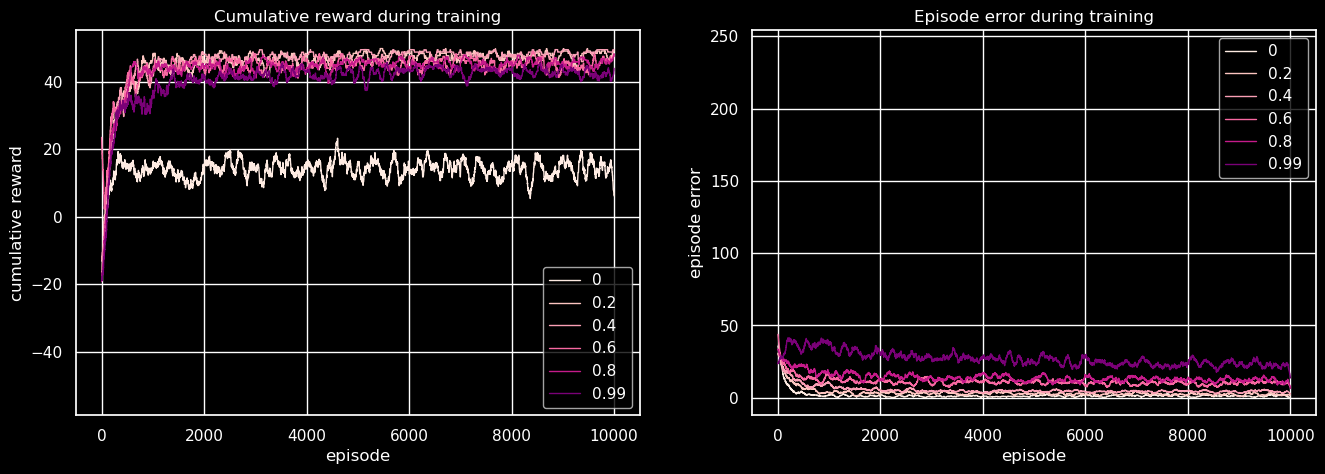

In [ ]:
plot_episodes(history, ['cumulative reward', 'episode error'],  alpha=0)
plt.show()

---
## Análise Q-Learning:

O Q-Learning é um método que utiliza um processo de iteração entre ação e valor, com a tabela Q sendo atualizada a cada etapa, considerando a recompensa imediata e o valor futuro máximo estimado para a próxima ação. Em essência, o Q-Learning é projetado para aprender a melhor estratégia de ação em um ambiente dinâmico, combinando informações imediatas e considerações de longo prazo para otimizar o desempenho do agente ao longo do tempo.

Nos experimentos realizados com o método Q-Learning, optamos por variar o parâmetro 𝞬, que é o fator de desconto. Este parâmetro controla a importância atribuída às recompensas futuras.

Em um ambiente determinístico, observamos que um valor de 𝞬 igual a 0 resultou no desempenho mais insatisfatório, observando a recompensa acumulada durante os episódios. Conforme aumentamos o valor de 𝞬, os resultados foram bastante semelhantes. Assim, fica evidente que alterar 𝞬 não exerce um impacto direto no desempenho do agente nesse contexto, uma vez que as consequências das ações são previsíveis.

Já em um ambiente estocástico, notamos que um valor de 𝞬 igual a 0 também levou ao pior resultado. À medida que 𝞬 foi aumentando, os resultados tornaram-se próximos, porém observamos uma maior dispersão. Isso indica uma influência mais significativa do valor de 𝞬 na performance do modelo nesse ambiente, uma vez que as ações podem gerar resultados diversos.

---

### SARSA($\lambda$)

In [ ]:
class SARSA:
    def __init__(self, env, gamma, lmbda, alpha=1., N0=1):
        self.env   = env
        self.gamma = gamma
        self.lmbda = lmbda
        self.alpha = alpha
        self.N0    = N0


    def train(self, policy, max_episodes=1000):
        history = {
            "cumulative reward"  : [],
            "episode error"      : [],
            "episode length"     : [],
            "episode win"        : []
        }

        Ntable = defaultdict(lambda : {action: 0 for action in Actions.actions})

        for _ in tqdm(range(max_episodes)):

            Etable  = defaultdict(lambda : {action: 0 for action in Actions.actions})

            state, done = self.env.reset(random_init = True)
            action = policy.act(state, epsilon=1)

            cumulative_reward = 0
            cumulative_error  = 0

            n_steps = 0

            while not done:
                Etable[state][action] = Etable[state][action] + 1

                next_state, reward, done, info = self.env.step(action)

                epsilon = self.N0 / (self.N0 + sum(Ntable[next_state].values()))

                next_action = policy.act(next_state, epsilon)

                Ntable[state][action] += 1
                n_steps += 1

                cumulative_reward = (self.gamma * cumulative_reward) + reward

                td_error = reward + self.gamma * policy.Q(next_state, next_action) - policy.Q(state, action)

                cumulative_error += abs(td_error)

                alpha = self.alpha/Ntable[state][action]

                for state in Etable:
                    for action in Actions.actions:
                        policy.update_Q(state, action, alpha, td_error * Etable[state][action])
                        Etable[state][action] *= self.gamma * self.lmbda

                state  = next_state
                action = next_action

            history["cumulative reward"].append(cumulative_reward)
            history["episode error"].append(cumulative_error)
            history["episode length"].append(n_steps)
            history["episode win"].append(self.env.is_win())

        return policy, history

In [ ]:
history, performance = evaluate(
    deterministic_env,
    EpsilonGreedyQAgent(),
    SARSA(deterministic_env.set_render(None), 0.99, 0),
    "lmbda",
    [0, 0.2, 0.4, 0.6, 0.8, 1]
)

performance

100%|██████████| 10000/10000 [01:49<00:00, 90.93it/s]


,Mean reward,Mean length,Mean winrate,Training time
0.0,43.0,7.0,1.0,9.123665
0.2,43.0,7.0,1.0,10.914383
0.4,43.0,7.0,1.0,9.251898
0.6,39.0,9.0,1.0,12.684554
0.8,-102.0,101.0,0.0,127.305371
1.0,-101.0,101.0,0.0,109.982211


In [ ]:
best = performance["Mean reward"].to_numpy().argmax()

results.loc[("Deterministic", "Classic", "SARSA"), :] = performance.iloc[best]

results

,,,Mean reward,Mean length,Mean winrate,Training time
Environment,Policy,Algorithm,,,,
Deterministic,Classic,Monte Carlo,37.0,11.0,1.0,9.943392
Stochastic,Classic,Monte Carlo,36.88,11.98,0.99,12.689994
Deterministic,Classic,Q-Learning,45.0,5.0,1.0,6.241794
Stochastic,Classic,Q-Learning,41.66,8.6,1.0,9.148927
Deterministic,Classic,SARSA,43.0,7.0,1.0,9.123665


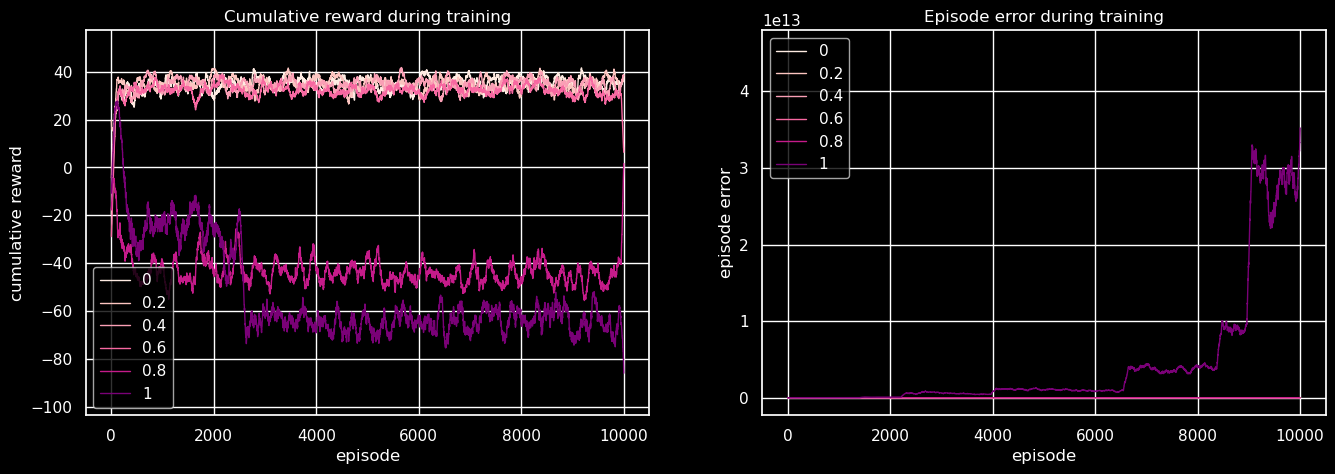

In [ ]:
plot_episodes(history, ['cumulative reward', 'episode error'],  alpha=0)
plt.show()

In [ ]:
history, performance = evaluate(
    stochastic_env,
    EpsilonGreedyQAgent(),
    SARSA(stochastic_env.set_render(None), 0.99, 0),
    "lmbda",
    [0, 0.2, 0.4, 0.6, 0.8, 1]
)

performance

100%|██████████| 10000/10000 [00:14<00:00, 683.75it/s]


,Mean reward,Mean length,Mean winrate,Training time
0.0,20.78,4.89,0.65,10.501673
0.2,41.54,8.44,1.0,11.656613
0.4,11.08,6.26,0.54,9.87147
0.6,28.62,20.3,0.98,26.997998
0.8,-27.32,36.34,0.39,35.332239
1.0,19.46,11.76,0.75,14.626842


In [ ]:
best = performance["Mean reward"].to_numpy().argmax()

results.loc[("Stochastic", "Classic", "SARSA"), :] = performance.iloc[best]

results

,,,Mean reward,Mean length,Mean winrate,Training time
Environment,Policy,Algorithm,,,,
Deterministic,Classic,Monte Carlo,37.0,11.0,1.0,9.943392
Stochastic,Classic,Monte Carlo,36.88,11.98,0.99,12.689994
Deterministic,Classic,Q-Learning,45.0,5.0,1.0,6.241794
Stochastic,Classic,Q-Learning,41.66,8.6,1.0,9.148927
Deterministic,Classic,SARSA,43.0,7.0,1.0,9.123665
Stochastic,Classic,SARSA,41.54,8.44,1.0,11.656613


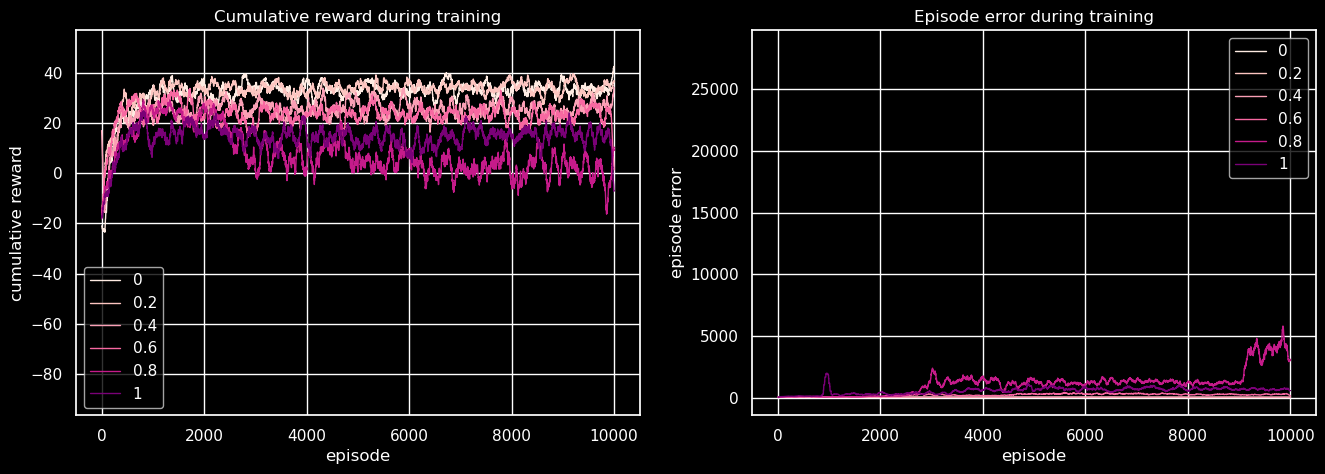

In [ ]:
plot_episodes(history, ['cumulative reward', 'episode error'],  alpha=0)
plt.show()

---
# Análise SARSA(λ)
A seguir, debateremos o comportamento do *backward-view* SARSA(λ). Nessa implementação, utilizamos uma e-table que é atualizada periodicamente com os traços de elegibilidade resgatados da exploração. Combinando informações de recência e frequência, ela tem como objetivo descobrir, dentre todos os estados, quais os mais influentes nos resultados presentes. A partir dessa informação, pondera-se a atualização através de toda a tabela. O traço de recência degrada de acordo com um valor λ, sendo ele um número entre 0 e 1 que multiplica repetidamente o peso armazenado na e-table.

Sobre os dados obtidos fazendo uso de diferentes valores de λ, torna-se possível explorar tanto características associadas ao comportamento geral do algoritmo quanto à própria natureza do ambiente ao qual ele foi exposto.

Nesse sentido, a avaliação dos valores médios de recompensa em ambientes tanto determinísticos quanto estocásticos aponta o aumento da variância e a maior dificuldade de convergência conforme atingimos maiores valores para λ. Esses fatores estão relacionados com a atualização significativa de estados distantes que guardam pouca semelhança com o atual a partir das recompensas registradas nesse.

Ademais, é notável a piora na qualidade da política extraída conforme usamos maiores λ. Isso nos indica que os estados guardam fraca correlação com suas origens; um sinal de que o agente deve priorizar a análise mais imediata da situação. De fato, essas observações estão em concordância com o próprio funcionamento do jogo analisado.  

---